In [127]:
import sys
#!{sys.executable} -m pip uninstall rasterio
#!{sys.executable} -m pip install --pre -U rasterio
#!{sys.executable} -m pip install affine
#!{sys.executable} -m pip install fiona
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install mplleaflet

In [2]:
import sys
import os
import json
import scipy
#import urllib
#import datetime 
#import urllib3
import rasterio
from affine import Affine
import fiona
#import subprocess
import numpy as np
import pandas as pd
#import seaborn as sns
from osgeo import gdal
#from planet import api
#from planet.api import filters
#from traitlets import link
#import rasterio.tools.mask as rio_mask
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, transform

In [3]:
with rasterio.open("/Users/brian/code/zv/zv/brazil/20170618_123226_100c/20170618_123226_100c_3B_AnalyticMS.tif") as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.transform)
    print(src.count)
    print(src.indexes)

9018 4368
+init=epsg:32723
| 3.00, 0.00, 314277.00|
| 0.00,-3.00, 8044602.00|
| 0.00, 0.00, 1.00|
4
(1, 2, 3, 4)


In [4]:
# FRom: https://github.com/kscottz/PythonFromSpace/blob/master/TheBasics.ipynb
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    path = os.path.abspath(os.path.join('./', filename))
    if os.path.exists(path):
        with rasterio.open(path) as src:
            b, g, r, nir = src.read()
            return np.dstack([r, g, b, nir])

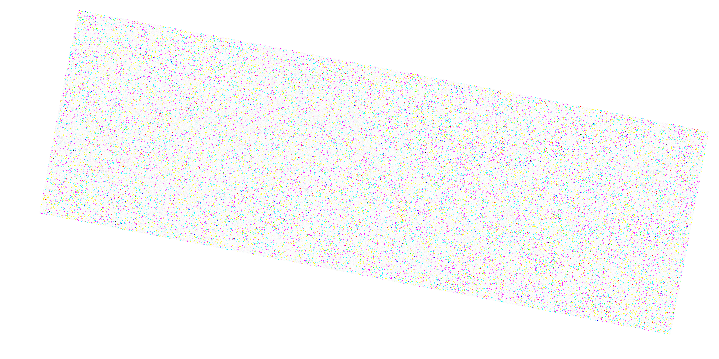

In [5]:
fb = load_image4("/Users/brian/code/zv/zv/brazil/20170618_123226_100c/20170618_123226_100c_3B_AnalyticMS.tif")
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(fb)
plt.show()

In [6]:
with open('/Users/brian/code/zv/zv/brazileuc.json') as data_file:    
    geoms= json.load(data_file)
print(geoms)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-46.57327651977538, -17.750321552001868], [-46.516971588134766, -17.750321552001868], [-46.516971588134766, -17.71157040121573], [-46.57327651977538, -17.71157040121573], [-46.57327651977538, -17.750321552001868]]]}}]}


In [7]:
g = geoms.get('geometry')
print(g)

None


In [8]:
with fiona.open('/Users/brian/code/zv/zv/brazileuc.json', "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
print(geoms)

[{'type': 'Polygon', 'coordinates': [[(-46.57327651977538, -17.750321552001868), (-46.516971588134766, -17.750321552001868), (-46.516971588134766, -17.71157040121573), (-46.57327651977538, -17.71157040121573), (-46.57327651977538, -17.750321552001868)]]}]


In [9]:
fb.shape

(4368, 9018, 4)

In [10]:
rs = transform.rescale(fb, 5/10) # this is skimage.transform
rs.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(2184, 4509, 4)

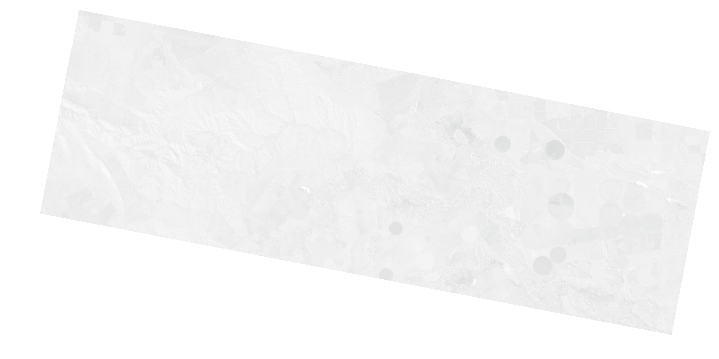

In [11]:
#rs = transform.rescale(fb, 5/10) # this is skimage.transform
#rs.shape
f, ax = plt.subplots(1, figsize=(12,24))
plt.set_cmap('jet')
plt.axis("off")
plt.imshow(rs)
plt.show()

In [25]:
# A function to calculate ECARR index, substituting LS8 Band 3 for Modis Band 1:
def calc_ecarr_using_band1(data_ecarr):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    lsband4 = data_ecarr[:,:,3] * 4.25585456224e-05 # 3 Red
    lsband3 = data_ecarr[:,:,2] * 2.85577526769e-05 # 2 Green

    # Renaming Landsat8 bands to MODIS bands:
    band1 = lsband4
    band4 = lsband3
    ecarr = 0.0161 * ((band1 / (band4 * band1) ) ** 0.7784)
    return(ecarr)


In [13]:
# A function to calculate NDVI:
def calc_nvdi(data_ecarr):
    #data_ecarr = img.read([3,2]).astype(np.float32)
    red = data_ecarr[:,:,0] * 2.42173976186e-05
    nir = data_ecarr[:,:,3] * 4.25585456224e-05
    nvdi = (nir - red)/(nir+red)
    return(nvdi)

# A function to calculate NDWI:
def calc_nwdi(data_ecarr):
    green = data_ecarr[:,:,2] * 2.42173976186e-05
    nir = data_ecarr[:,:,3] * 4.25585456224e-05
    nvdi = (green - nir )/(nir+green)
    return(nvdi)

In [66]:
# above, I have manually grabbed reflectance normalizing values.  Should do something like this:
from xml.dom import minidom

xmldoc = minidom.parse("/Users/brian/code/planet/20180815_003119_100d/20180815_003119_100d_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

In [67]:
print(coeffs)

{1: 2.42173976186e-05, 2: 2.56164546152e-05, 3: 2.85577526769e-05, 4: 4.25585456224e-05}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


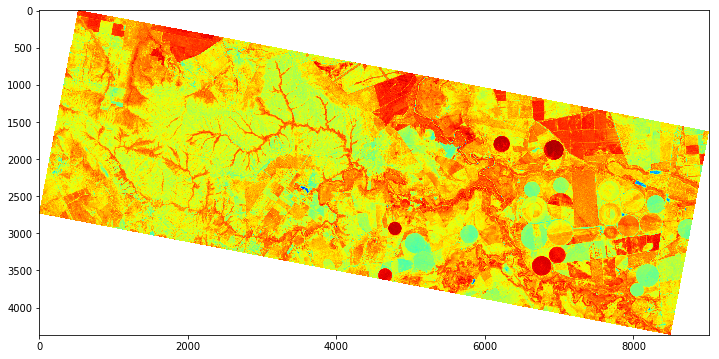

In [14]:
f, ax = plt.subplots(1, figsize=(12,24))
#t = calc_ecarr_using_band1(fb)
t = calc_nvdi(fb)
plt.set_cmap('jet')
plt.imshow(t)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


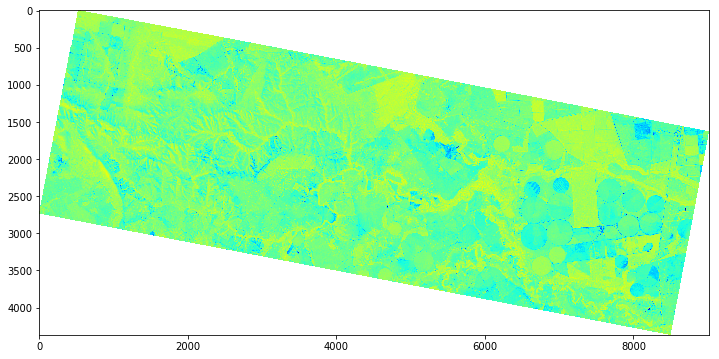

In [15]:
f, ax = plt.subplots(1, figsize=(12,24))
t = calc_ecarr_using_band1(fb)
#t = calc_nvdi(fb)

plt.set_cmap('jet')
plt.imshow(t)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


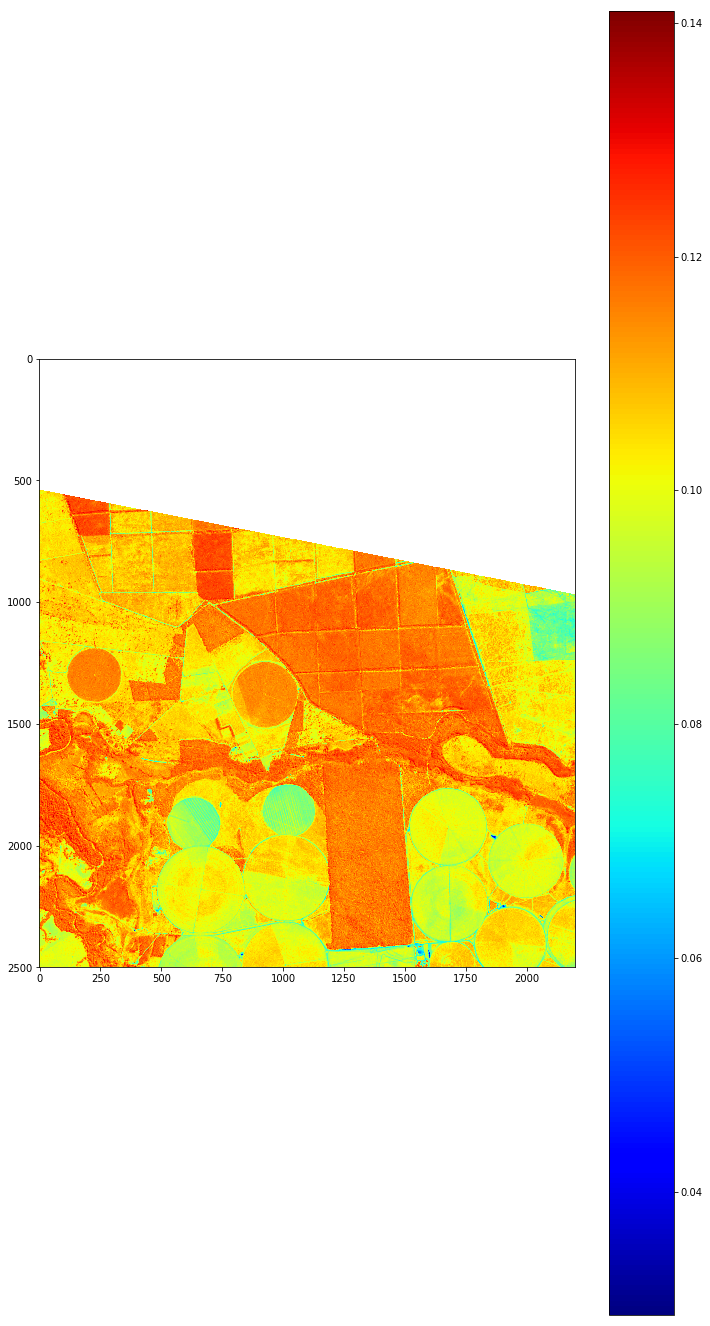

In [28]:
f, ax = plt.subplots(1, figsize=(12,24))
nrs = fb[500:3000,6000:8200]
nrs.shape
t = calc_ecarr_using_band1(nrs)
plt.set_cmap('jet')
plt.imshow(t)
plt.colorbar()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


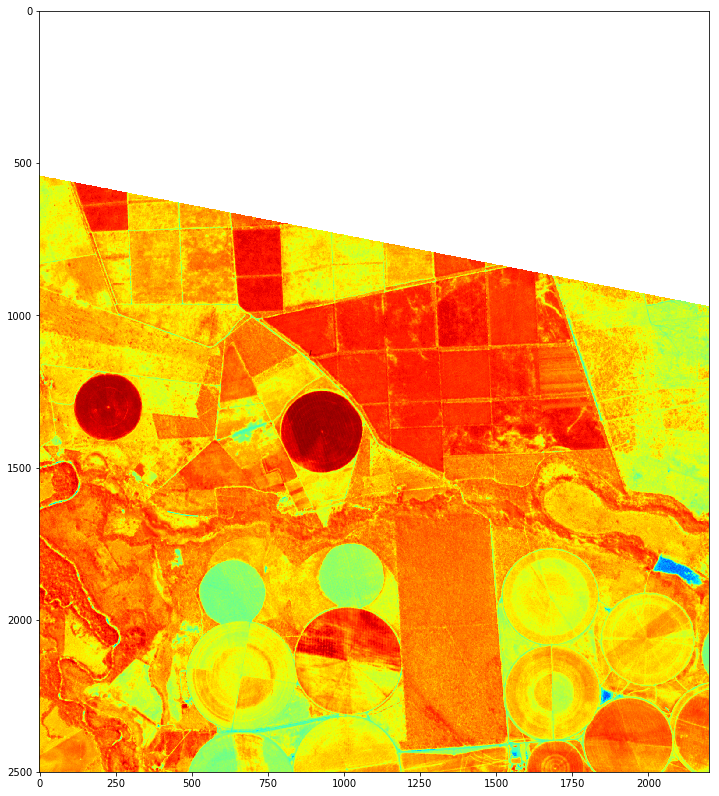

In [21]:
f, ax = plt.subplots(1, figsize=(12,24))
#nrs = fb[1500:3500,500:3500]
nrs = fb[500:3000,6000:8200]
#nrs.shape
t = calc_nvdi(nrs)
plt.set_cmap('jet')
plt.imshow(t)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


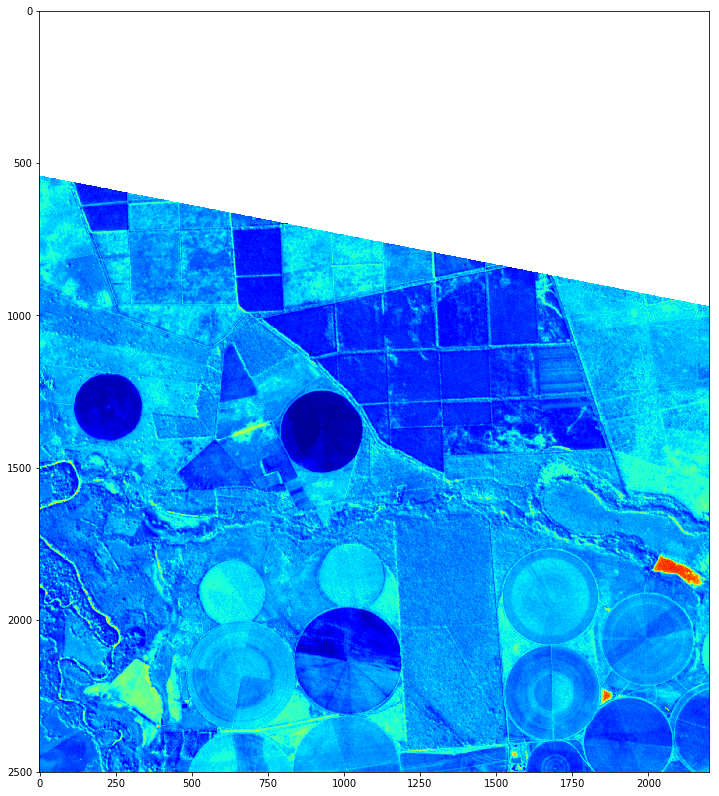

In [27]:
f, ax = plt.subplots(1, figsize=(12,24))
#nrs = fb[1500:3500,500:3500]
nrs = fb[500:3000,6000:8200]
#nrs.shape
t = calc_nwdi(nrs)
plt.set_cmap('jet')
plt.imshow(t)
plt.show()